# Neural Style Transfer CNNs
By David Tarazi and Dieter Brehm, October 2019

## Setup
Import libraries and a local utility script for the sake of shortening and simplifying the code shown in this report notebook.

In [1]:
import MLUtility as util
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if tf.__version__ != "1.14.0":
    print("Warning, tensorflow version not compatible with this notebook")
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
# show live results if running TF -> 1.14
tf.enable_eager_execution()

In [3]:
# download two test images
#content_path = tf.keras.utils.get_file('olin.jpg','https://github.com/Inkering/ML-Project-1/blob/master/71934026_761426527628858_7267766954746707968_n.png?raw=true')
#style_path = tf.keras.utils.get_file('painting.jpg','https://github.com/Inkering/ML-Project-1/raw/master/StarryNight.jpg')
content_path = "turtle.png"
style_path = "wave.png"

## Looking at the two inputs
Quickly visualize the two images we will applying filters onto, i.e. the style image we will be getting style information from and the content image we will be applying a generated convolution filter onto to make it look like the style of the style image. For now, we'll look at the two unmodified inputs.

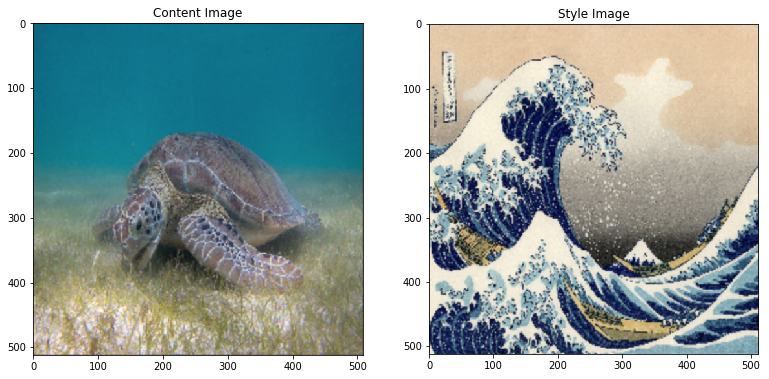

In [4]:
content_image = util.transform_image(content_path, 512)
style_image = util.transform_image(style_path, 512)
fig = plt.gcf()
fig.set_size_inches(13,8)
plt.subplot(1, 2, 1)
util.imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
util.imshow(style_image, 'Style Image')

## Let Keras preprocess the input to fit desired dimensionality
Next, we'll use Keras to preprocess the input image to work with the vgg model we will transfer learning with. The process involves scaling it into a square and increasing the pixel values.

**Q: should we tune the 200 brightness variable and check results?**  
**Q: why do we adjust brightness at all? does it work without it?**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


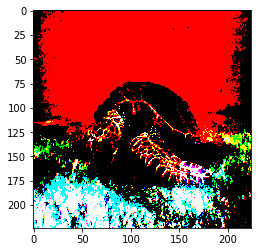

In [5]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*200)
x = tf.image.resize(x, (224, 224))
util.imshow(x)

## (Cool) What does the VGG model think the input looks like?
We can quickly run a classification on the input, after all, that is what vgg is actually for despite the fact that we are essentially intercepting the intermediary layers before a squashing and classification occurs. It is interesting to see what it thinks the olin O is though!

In [6]:
# download Keras
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
# show the top 5 predictions
predicted = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted]

[('loggerhead', 0.69838244),
 ('leatherback_turtle', 0.18069981),
 ('hermit_crab', 0.0450422),
 ('terrapin', 0.036484282),
 ('mud_turtle', 0.014818196)]

## Implementing transfer learning and style content loss
**A note on how the loss function works in this implementation**:  
Basically, the content loss function is calculating the sum of the mean squared
error between the generated image and the content image. The activations in the
higher layers of the generated image often represent objects shown in the
image. So the content loss function focuses on the higher layers correlated
specifically to objects or content.

On the other hand, the style loss function looks at all of the layers in the
CNN. style information is measured as the amount of correlation present between
features maps in a given layer. Next, a loss is defined as the difference of
correlation present between the feature maps computed by the generated image and
the style image.

First, we'll pick layers to work with for the content and style representations:

**Q**: How does the number of style layers chosen, and which content layer chosen, change the algorithm output?

In [7]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Then, according to idiosyncrasies of the model format, we need to create a new version of the model which involves feeding only the desired layers we wrote above of the VGG classifier network into a new model which only considers those layers. After creating this limited model compared to the massive VGG classifier system, we can apply the style image to it and get some outputs for those given layers!

In [8]:
style_model = util.vgg_2_functional_model(style_layers)
style_outputs = style_model(style_image*255)


This gives us a set of outputs, but we need a method to combine them so that we can quantitatively compare it to the content and compute a loss which we can later perform gradient descent on. One method is to use a gram matrix:

In [9]:
def gram_matrix(input_tensor):
    # Finds the correlation matrix for style loss and sums all of the feature correlations for a particular layer
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    # num_locations is the same as number of pixels
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # normalize
    return result/(num_locations)

In our utilities script, we define a shortcut class that allows us to repeatedly call a function that generates style and content outputs. It utilizes the gram matrix to combine the outputs of the style layers. It returns both that combined style output matrix and the outputs given from passing the content image through the model.

In [10]:
# create an instance of the class described above
model_instance = util.StyleContentModel(style_layers, content_layers)

results = model_instance.call(tf.constant(content_image))

### Visualizing a intermediary style layer
Each style layer is a tensor that holds style information as a gram matrix. We can look at a visual representation of it and examine its shape!

(1, 64, 64)
(8, 8, 64)


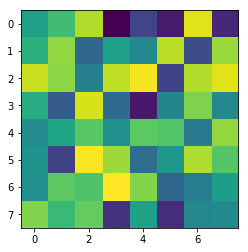

In [12]:
#pluck out a layer and convert to np array
layer_shown = results["style"]["block1_conv1"]
print(layer_shown.shape)
layer_shown = layer_shown*255
layer_shown = np.array(layer_shown, dtype=np.uint8)

#reshape to an image size
layer_shown = np.reshape(layer_shown,(8,8,64))

print(layer_shown.shape)
plt.imshow(layer_shown[:,:,0])

### Preparing the experiment
Now, we can run a gradient descent and get a significant style transfer output! Firstly, by setting the targets we will run our functions against.

In [13]:
# Setting the targets by pulling them out of the run model instance
style_targets = model_instance(style_image)['style']
content_targets = model_instance(content_image)['content']

# Defining the image as a tensorflow variable to make it constant
image = tf.Variable(content_image)

Defining the optimizer - we can tune the learning rate and beta value (decay rate for first moment estimates)



In [14]:
opt = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.99, epsilon=1e-1)

As with all gradient descents, we need to choose a starting point

In [15]:
style_weight=1e-2
content_weight=1e4

**Q: should we include the loss function or is the explanation and maybe some latex sufficient?**

## Running the experiment

In [ ]:
experiment = util.experiment_handler(content_image,
                                     model_instance,
                                     style_targets,
                                     content_targets,
                                     style_weight,
                                     content_weight,
                                     num_style_layers,
                                     num_content_layers)
experiment.run(10,10)

### Looking at the loss over experiment runs

In [ ]:
plt.figure()
plt.plot(experiment.losses)
plt.title("Gradient Descent loss versus run for style transfer")
plt.xlabel("Run Number")
plt.ylabel("Loss")
plt.show()